http://etccdi.pacificclimate.org/list_27_indices.shtml?fbclid=IwAR0FN66bZwVBBmXVDyYNsf6nZ5W-rmTBo8jOH5Vt-ir0GyH0dDaeMLUtC1s


https://xclim.readthedocs.io/en/stable/icclim.html

In [1]:
import numpy as np
import xarray as xr
from datetime import datetime
import cftime
import matplotlib.pyplot as plt


In [4]:
xr.open_zarr('/datadrive/cam5/nat_hist_zarr')

<xarray.Dataset>
Dimensions:  (height: 2, lat: 192, lon: 288, run: 9, time: 20621)
Coordinates:
  * height   (height) float32 0.0 2.0
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * run      (run) int64 1 2 3 4 5 7 8 9 10
  * time     (time) object 1959-01-01 12:00:00 ... 2015-06-30 12:00:00
Data variables:
    pr       (run, time, height, lat, lon) float32 dask.array<chunksize=(1, 1, 2, 192, 288), meta=np.ndarray>
    tas      (run, time, height, lat, lon) float32 dask.array<chunksize=(1, 1, 2, 192, 288), meta=np.ndarray>
    tasmax   (run, time, height, lat, lon) float32 dask.array<chunksize=(1, 1, 2, 192, 288), meta=np.ndarray>
    tasmin   (run, time, height, lat, lon) float32 dask.array<chunksize=(1, 1, 2, 192, 288), meta=np.ndarray>

In [2]:
from climatetranslation.unit.data import construct_regridders, reduce_height, get_dataset
from climatetranslation.diagnostics import indices

ModuleNotFoundError: No module named 'climatetranslation'

In [4]:
reduce_dict = {0: ['pr'], 2: ['tas', 'tasmin', 'tasmax']}

In [5]:
ds_cam = get_dataset('/datadrive/cam5/nat_hist_zarr', level_vars=reduce_dict)
ds_had = get_dataset('/datadrive/hadgem3/nat_hist_zarr', level_vars=reduce_dict)
ds_cam2had = get_dataset('/datadrive/cam5/nat_hist_to_hadgem3_4ch_zarr')

In [7]:
ds_cam.tas

<xarray.DataArray 'tas' (run: 9, time: 20621, lat: 192, lon: 288)>
dask.array<getitem, shape=(9, 20621, 192, 288), dtype=float32, chunksize=(1, 1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * time     (time) object 1959-01-01 12:00:00 ... 2015-06-30 12:00:00
  * run      (run) int64 1 2 3 4 5 7 8 9 10
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
Attributes:
    long_name:      Near-Surface Air Temperature
    original_name:  TREFHT
    standard_name:  air_temperature
    units:          K

In [7]:
rg_cam, rg_had = construct_regridders(ds_cam, ds_had)

# attributes are stripped by regridding module. Save them
cam_attrs = {v:ds_cam[v].attrs for v in ds_cam.keys()}
had_attrs = {v:ds_cam[v].attrs for v in ds_cam.keys()}

# regridders allow lazy evaluation
ds_cam = ds_cam if rg_cam is None else rg_cam(ds_cam).astype(np.float32)
ds_had = ds_had if rg_had is None else rg_had(ds_had).astype(np.float32)

# reapply attributes
for v, attr in cam_attrs.items():
    ds_cam[v].attrs = attr
for v, attr in had_attrs.items():
    ds_had[v].attrs = attr

Create weight file: bilinear_324x432_192x288_peri.nc
Remove file bilinear_324x432_192x288_peri.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


In [8]:
for v in ds_cam2had.variables:
    try:
        ds_cam2had[v].attrs['units'] =  ds_had[v].attrs['units']
    except:
        print(f'skipping {v}')

skipping lon
skipping run
skipping time
skipping lat


In [9]:
%time ds_ = ds_cam.isel(run=slice(0, 1), time=slice(0, None)).compute()

CPU times: user 1min 26s, sys: 33.8 s, total: 2min
Wall time: 2min 23s


In [17]:
ds_dev = ds_.sel(lat=slice(-10, 10), lon=slice(0,10))

In [11]:
%cd ../..
import indices
%cd notebooks/data_analysis

/home/dfulu/repos/climateTranslation
/home/dfulu/repos/climateTranslation/notebooks/data_analysis


In [167]:
import imp
%cd ../..
import indices.etccdi
imp.reload(indices)
imp.reload(indices.etccdi)
import indices
%cd notebooks/data_analysis

/home/dfulu/repos/climateTranslation
/home/dfulu/repos/climateTranslation/notebooks/data_analysis


In [18]:
%time ds_dev_ref = indices.prepare_reference(ds_dev)

CPU times: user 37.5 s, sys: 0 ns, total: 37.5 s
Wall time: 37.5 s


In [168]:
%time ds_dev_ind = indices.apply_all_indices(ds_dev, ds_dev_ref)

100% (27 of 27) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


CPU times: user 12.8 s, sys: 1.58 s, total: 14.4 s
Wall time: 14.3 s


In [140]:
ds_dev_ind

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 9, month: 12)
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0
  * lat      (lat) float32 -9.8952875 -8.95288 -8.010471 ... 8.95288 9.8952875
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    FD       (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SU       (lat, lon) float64 0.08953 0.09061 0.09624 ... 0.7895 0.8287 0.868
    ID       (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TR       (lat, lon) float64 0.7767 0.7332 0.7006 ... 0.5111 0.5434 0.6138
    GSL      (lat, lon) float64 352.5 352.5 352.5 352.5 ... 359.0 359.0 359.0
    TX_x     (month, lat, lon) float32 297.23654 297.2795 ... 304.19598 305.1801
    TN_x     (month, lat, lon) float32 296.77127 296.8273 ... 291.0024 292.64087
    TX_n     (month, lat, lon) float32 295.57025 295.5716 ... 298.99457 299.6205
    TN_n     (month, lat, lon) float32 295.02393 295.01996 ... 287.58524
    TN10p    (lat, lon) float64 0.09917 0.09922 0.09815 ... 0.1004 0.1004 0.1019
    TX10p    (lat, lon) float64 0.1002 0.09932 0.09849 ... 0.1015 0.1009 0.09976
    TN90p    (lat, lon) float64 0.1009 0.1006 0.1004 ... 0.09966 0.09795 0.09868
    TX90p    (lat, lon) float64 0.1002 0.1014 0.1003 ... 0.1021 0.1002 0.1016
    WSDI     (lat, lon) float64 17.58 18.27 17.35 17.58 ... 7.691 7.509 7.455
    CSDI     (lat, lon) float64 13.95 15.55 15.33 14.64 ... 6.236 6.345 7.8
    DTR      (month, lat, lon) float32 0.5047627 0.5084007 ... 12.662812
    Rx1day   (month, lat, lon) float32 0.55922836 0.49283543 ... 0.39379865
    Rx5day   (month, lat, lon) float32 1.656455 1.4605356 ... 0.64927834
    SDII     (lat, lon) float32 2.1239939 2.4264555 ... 6.759897 6.5982146
    R10mm    (lat, lon) float64 9.785e-05 9.785e-05 4.893e-05 ... 0.1051 0.09673
    R20mm    (lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.01111 0.00822 0.006752
    CDD      (lat, lon) float64 234.3 265.4 298.9 306.9 ... 71.04 74.57 76.16
    CWD      (lat, lon) float64 2.339 1.875 1.589 1.607 ... 55.39 48.75 47.61
    R95pTOT  (lat, lon) float32 16.60217 15.42187 ... 226.75768 214.96313
    R99pTOT  (lat, lon) float32 6.7123513 6.148449 ... 72.61766 69.792274
    PRCPTOT  (lat, lon) float32 10.771684 8.969217 ... 1323.6119 1261.4393

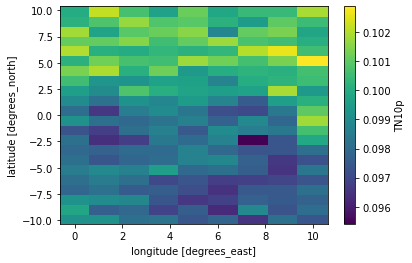

In [154]:
ds_dev_ind.TN10p.plot()

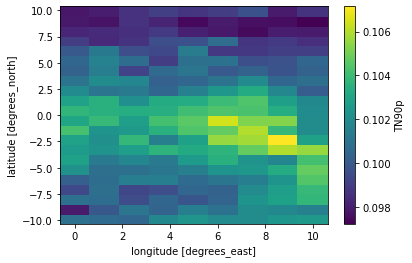

In [155]:
ds_dev_ind.TN90p.plot()

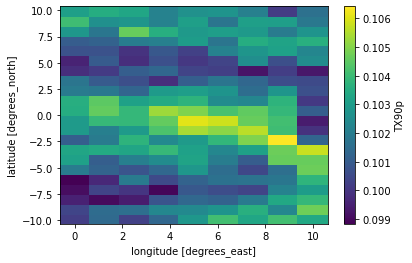

In [156]:
ds_dev_ind.TX90p.plot()

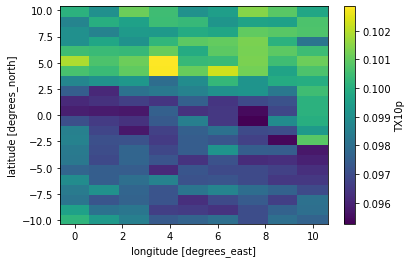

In [157]:
ds_dev_ind.TX10p.plot()